In [8]:
import os
import os.path 
import cv2
import tkinter as tk
import tkinter.filedialog as fd
from PIL import Image
from skimage import transform, img_as_int, exposure
import skimage.io as io
import skimage as si
import tkinter.messagebox as mb
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage, spatial
from cmath import inf
import sys
import numpy as np
from scipy.optimize import curve_fit
import json
from Bio import SeqIO
from skimage.filters import gaussian
import pandas as pd
from skimage.feature import peak_local_max
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from math import floor, ceil, exp
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
from scipy.io import savemat
import Polywarp


root = tk.Tk()
root.attributes("-topmost", True)
root.withdraw()

''

In [9]:
def get_pos(record):
    
    des = record.description
    tile_num = int(des.split(' ')[0].split(':')[4])
    x_pos = int(des.split(' ')[0].split(':')[5])
    y_pos = int(des.split(' ')[0].split(':')[6])
    return tile_num, x_pos, y_pos


def generate_img(x, y, x_min, y_min, x_max, y_max, r, blurred, sigma):
    # x_min = min(x)
    # x_max = max(x)
    # y_min = min(y)
    # y_max = max(y)
    x_range = x_max - x_min
    y_range = y_max - y_min
    # x_range = 27994
    # y_range = 27174
    img = np.zeros(shape=(x_range, y_range))
    for i in range(0, len(x)):
        img[min(x_range-1,max(0,int(x[i]-r))):min(x_range-1,max(0,int(x[i]+r+1))),min(y_range-1,max(0,int(y[i]-r))):min(y_range-1,max(0,int(y[i]+r+1)))] = 200

    if blurred:
        img = gaussian(img, sigma=sigma)
    im = Image.fromarray(img)
    new_im = im.convert("L")
#     new_im.save(op_path)
    return new_im


def generate_with_marker(x, y, marker_x, marker_y, op_path, csv_path):
    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    x_range = x_max - x_min + 1
    y_range = y_max - y_min + 1
    img = np.zeros(shape=(x_range, y_range, 3))
    marker_dic = {'index': range(0, len(marker_x)), 'x': [], 'y': []}
    for i in range(0, len(x)):
        for j in range(0, 5):
            for k in range(0, 5):
                img[max(0, x[i] - x_min - j),
                    max(0, y[i] - y_min - k), 0:3] = 255
                img[min(x_range - 1, x[i] - x_min + j),
                    max(0, y[i] - y_min - k), 0:3] = 255
                img[min(x_range - 1, x[i] - x_min + j),
                    min(y_range - 1, y[i] - y_min + k), 0:3] = 255
                img[max(0, x[i] - x_min - j),
                    min(y_range - 1, y[i] - y_min + k), 0:3] = 255
    for i in range(0, len(marker_x)):
        marker_dic['x'].append(marker_x[i] - x_min)
        marker_dic['y'].append(marker_y[i] - y_min)
        for j in range(0, 5):
            for k in range(0, 5):
                img[max(0, marker_x[i] - x_min - j),
                    max(0, marker_y[i] - y_min - k), 0] = 255
                img[max(0, marker_x[i] - x_min - j),
                    max(0, marker_y[i] - y_min - k), 1:3] = 0
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    max(0, marker_y[i] - y_min - k), 0] = 255
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    max(0, marker_y[i] - y_min - k), 1:3] = 0
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    min(y_range - 1, marker_y[i] - y_min + k), 0] = 255
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    min(y_range - 1, marker_y[i] - y_min + k), 1:3] = 0
                img[max(0, marker_x[i] - x_min - j),
                    min(y_range - 1, marker_y[i] - y_min + k), 0] = 255
                img[max(0, marker_x[i] - x_min - j),
                    min(y_range - 1, marker_y[i] - y_min + k), 1:3] = 0
    blurred_img = gaussian(img, sigma=3, multichannel=True)
    im = Image.fromarray(blurred_img.astype(np.uint8))
    new_im = im.convert("P")
    new_im.save(op_path)
    df = pd.DataFrame(marker_dic)
    df.to_csv(csv_path, index=True, header=True)


def get_coordinates(fastq_path):
    x_coordinate_01 = []
    y_coordinate_01 = []
    x_coordinate_02 = []
    y_coordinate_02 = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == 1101:
                x_coordinate_01.append(x_pos)
                y_coordinate_01.append(y_pos)
            elif tile_num == 1102:
                x_coordinate_02.append(x_pos)
                y_coordinate_02.append(y_pos)
    print('Coordinates are found.')
    return x_coordinate_01, y_coordinate_01, x_coordinate_02, y_coordinate_02


def get_xy_coordinates(fastq_path, with_seq):
    x_coordinate_01 = []
    y_coordinate_01 = []
    x_coordinate_02 = []
    y_coordinate_02 = []
    x_seq_coordinate_01 = []
    y_seq_coordinate_01 = []
    x_seq_coordinate_02 = []
    y_seq_coordinate_02 = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == 1101:
                if with_seq != seq:
                    x_coordinate_01.append(x_pos)
                    y_coordinate_01.append(y_pos)
                else:
                    x_seq_coordinate_01.append(x_pos)
                    y_seq_coordinate_01.append(y_pos)
            elif tile_num == 1102:
                if with_seq != seq:
                    x_coordinate_02.append(x_pos)
                    y_coordinate_02.append(y_pos)
                else:
                    x_seq_coordinate_02.append(x_pos)
                    y_seq_coordinate_02.append(y_pos)
    print('Coordinates are found.')
    return x_coordinate_01, y_coordinate_01, \
        x_coordinate_02, y_coordinate_02, \
        x_seq_coordinate_01, y_seq_coordinate_01, \
        x_seq_coordinate_02, y_seq_coordinate_02


def get_seq_coordinates(fastq_path, tile):
    x_coordinate = []
    y_coordinate = []
    sequences = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == tile:
                x_coordinate.append(x_pos/10)
                y_coordinate.append(y_pos/10)
                sequences.append(seq)
#     print('Coordinates are found.')
    return x_coordinate, y_coordinate, sequences

def find_max (x,y, arr):
    
    print(np.shape(arr))
    print((arr))
    max_elem = -1
    for i in range(x-5, x+6):
        for j in range(y-5, y+6):
            if arr[j][i] > max_elem:
                max_elem =  arr[j][i]

    list_index_max =[(i,j) for i in range(x-5, x+6)  for j in range(y-5, y+6) if arr[j][i]  == max_elem]
    line, column = list_index_max[0]
    return(line, column)
#https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/  
# function to display the coordinates of  of the points clicked on the image


def click_event_FRET(event, x, y, flags, params):
    global counter
    global FRET_coord
    if event == cv2.EVENT_LBUTTONDOWN:   # checking for left mouse clicks   
        x_max,y_max = find_max(x,y,image_array_F)
        print(x_max, y_max)
        FRET_coord.append(x_max) 
        FRET_coord.append(y_max)
        cv2.circle(better_contrast_img, (x_max, y_max), 4, (0, 0, 127), 2)
        counter+=1    
    if event==cv2.EVENT_RBUTTONDOWN:
        counter = 0
        green_coord.clear()
        red_coord.clear()
        
def click_event_seq(event, x, y, flags, params):
    global counter
    global seq_coord
    if event == cv2.EVENT_LBUTTONDOWN:   # checking for left mouse clicks   
        x_max,y_max = find_max(x,y,image_array_seq_t)
        print(x_max, y_max)
        seq_coord.append(x_max) 
        seq_coord.append(y_max)
        cv2.circle(better_contrast_img_2, (x_max, y_max), 4, (0, 0, 127), 2)
        counter+=1   
    if event==cv2.EVENT_RBUTTONDOWN:
        counter = 0
        green_coord.clear()
        red_coord.clear()


def scaling_seq (x, y):
    #x = int(1700 + (x - 27246.18)/0.34 ) ### tile 2
    #y = int(1571 - (y + 1149.66)/0.34)
    x = int(2329 + (x - 28522.9)/0.34)  ### tile 1 
    y = int(2042 - (y + 1313.3)/0.34)
    
    
    return (x,y)
    

def blob_detection(img, min_sigma, max_sigma, threshold, method=0):
    """This function is mostly used for detecting the beads in any image.

    Args:
        img_path (string): The absolute path of the input image.
        min_sigma (int): The minimum sigma, lower it is, smaller the blob will be detected.
        max_sigma (int): The maximum sigma, higher it is, bigger the blob will be detected.
        threshold (float): Higher it is, higher the intensities of blobs.
        method (int, optional): 0 for Difference of Gaussian (DoG) and 1 for Determinant of Hessian (DoH). 
        They should be applied with different combination of parameters. DoG is more suitable for fret movies,
        while DoH is more suitable for sequencing images. Defaults to 0.

    Returns:
        centers: A numpy array containing the coordinates of all the centers.
    """
    #img = io.imread(img_path)
    if method == 0:
        blob = blob_dog(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    else:
        blob = blob_doh(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    i = 0
    # r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, r = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(centers[i], [x - r, y - r]))
            i += 1
    return np.array(centers)

def count_nearest_pts(src, dst, radius):
    """Counting the number of nearest neighbors for each given point.

    Args:
        src (numpy array): (N, 2) shape array. Build the kd tree based on this.
        dst (numpy array): (N, 2) shape array. For each point in this array, find the nearest neighbors in src array.
        radius (int): The maximum searching radius.

    Returns:
        res, idx: res is the distance for the point and its neighbor, 'inf' means no neighbor in given search radius. 
        idx is the index for the neighbor in src array.
    """
    tree = spatial.KDTree(src)
    res, idx = tree.query(dst, k=1, distance_upper_bound=radius)
    for i in range(0, len(idx)):
        if len(np.argwhere(idx == idx[i])) > 1:
            res[i] = inf
    return res, idx

class App(tk.Tk):
    
    def __init__(self):
        super().__init__()
        btn_file = tk.Button(self, text="Choose file",
                             command=self.choose_file)
        btn_dir = tk.Button(self, text="Choose folder",
                             command=self.choose_directory)
        btn_file.pack(padx=60, pady=10)
        btn_dir.pack(padx=60, pady=10)
        

    def choose_file(self):
        filetypes = (("All formats ", "*"),
                     ("Text file", "*.txt"),
                     ("Image", "*.jpg *.gif *.png *.bmp *.tif"))
        filename = fd.askopenfilename(title="Open file", initialdir="/",
                                      filetypes=filetypes)
        if filename:
            self.st = filename
            #print (filename)
           
            
    def choose_directory(self):
        directory = fd.askdirectory(title="Open folder", initialdir="/")
        if directory:
            self.dir = directory
            print (directory)


In [10]:
#Instead of calculating the bead mapping we can load the transformation generated with channel_map


tr_G2R = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the forward transform file", initialdir = "C:/Users/Anton/Documents/Jupyter home/ExampleData/Test_folder/220717_FC_Nano_200nm_Multicolor/original")
tr_G2R.params = np.load(file_path)
tr_R2G = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the inverse transform file", initialdir = os.path.dirname(file_path))
tr_R2G.params = np.load(file_path)

path_smFRET = fd.askdirectory(title = "Choose the smFRET folder", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/green")
# path_smFRET = fd.askdirectory(title = "Choose the smFRET movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/green")


In [11]:
# fastq_path = 'E:/MUSCLE data/0722.fastq'
fastq_path = fd.askopenfilename(title = "Choose the FASTQ file", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/")


x_coord, y_coord, sequence = get_seq_coordinates(fastq_path,  tile=1101)
# print(len(x_coordinate_01))
# print(len(x_coordinate_02))
# print(np.max(x_coordinate_01))
# print(np.min(x_coordinate_01))

# max_y  = max (y_coord)
# max_x = max (x_coord)
max_y  = max_x = 3000 # To ensure that the alignment is not affected by changes in max x and y


x_coord1 = np.subtract(max_y, y_coord)
y_coord = np.subtract(max_x, x_coord)

x_coord = x_coord1

# Correction for the shift between FASTQ and cluster images
x_coord = np.subtract(x_coord, 97.5)
y_coord = np.subtract(y_coord, 3)

max_x1 = ceil(max_y)
max_y = ceil(max_x)
max_x = max_x1
# max_x = ceil(max_x)
# max_y = ceil(max_y)

# generate_with_marker(x_coordinate_01, y_coordinate_01, x_coordinate_01m, y_coordinate_01m,
#   '/Users/qinhanhou/Desktop/DeindlLab/220722/SeqImg/1101_marked_sigma3.png',
#   '/Users/qinhanhou/Desktop/DeindlLab/220722/SeqImg/1101_marked_sigma3.csv')

library_seq =  'GGTCTCGTCCAATCTAT'

['Pos148', 'Pos149', 'Pos150', 'Pos151', 'Pos152', 'Pos153', 'Pos154', 'Pos155', 'Pos180', 'Pos181', 'Pos182', 'Pos183', 'Pos184', 'Pos185', 'Pos186', 'Pos187', 'Pos214', 'Pos215', 'Pos216', 'Pos217', 'Pos218', 'Pos219', 'Pos220', 'Pos221', 'Pos246', 'Pos247', 'Pos248', 'Pos249', 'Pos250', 'Pos251', 'Pos252', 'Pos253', 'Pos280', 'Pos281', 'Pos282', 'Pos283', 'Pos284', 'Pos285', 'Pos286', 'Pos287', 'Pos312', 'Pos313', 'Pos314', 'Pos315', 'Pos316', 'Pos317', 'Pos318', 'Pos319', 'Pos346', 'Pos347', 'Pos348', 'Pos349', 'Pos350', 'Pos351', 'Pos352', 'Pos353', 'Pos378', 'Pos379', 'Pos380', 'Pos381', 'Pos382', 'Pos383', 'Pos384', 'Pos385', 'Pos412', 'Pos413', 'Pos414', 'Pos415', 'Pos416', 'Pos417', 'Pos418', 'Pos419', 'Pos444', 'Pos445', 'Pos446', 'Pos447', 'Pos448', 'Pos449', 'Pos450', 'Pos451', 'Pos478', 'Pos479', 'Pos480', 'Pos481', 'Pos482', 'Pos483', 'Pos484', 'Pos485']
64 2571
387 2571


NameError: name 'image_array_2' is not defined

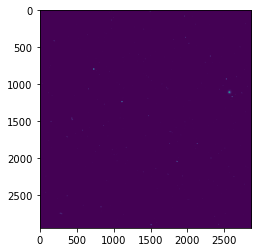

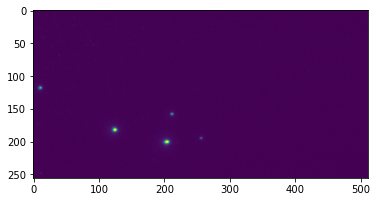

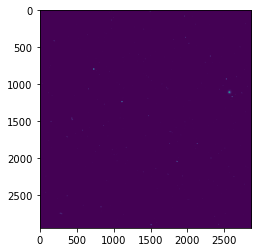

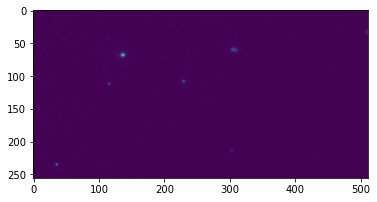

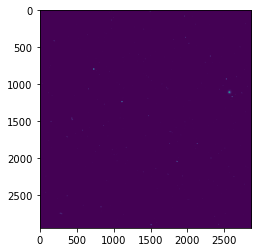

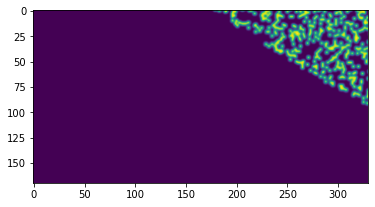

In [15]:


file_path = fd.askopenfilename(title = "Choose the position list", initialdir = "D:/Experiments/MUSCLE DONUTS/")
current_direct = fd.askdirectory(title = "Choose the temp folder", initialdir = "D:/Experiments/MUSCLE DONUTS/")


pos_file = open(file_path)
data = json.load(pos_file)
POS = data['POSITIONS']

labels = [P['LABEL'] for P in POS]
posX = [P['DEVICES'][0]['X'] for P in POS]
posY = [P['DEVICES'][0]['Y'] for P in POS]


#X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos287']
#Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos287']

labels_res = []
posX_res = []
posY_res = []
for i,x in enumerate(labels):
    #x = int(1700 + (posX[i] - 27246.18)/0.34) #tile 2
    #y = int(1571 - (posY[i] + 1149.66)/0.34)   
    x = int(2329 + (posX[i] - 28522.9)/0.34) # tile 1
    y = int(2042 - (posY[i] + 1313.3)/0.34) 
    if (x > 0 ) and (y > 0):
        if (y+170<2866) and (x+330 < 2944) :
            labels_res.append (labels[i])
            posX_res.append (posX[i])
            posY_res.append( posY[i])


print (labels_res)

#print(usable_green_beads)
#print(usable_red_beads)
fastq_image = generate_img(y_coord,x_coord, 0, 0, max_y, max_x, 1, True, 1)
fastq_image.save(os.path.join(current_direct, 'FASTQ_image.png'))


counter = 0  

file_path = fd.askopenfilename(title = "Choose the MIN projection image", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/")
seq = io.imread(file_path)#reading the sequence image
seq = seq.astype("ushort") 

file_path = fd.askopenfilename(title = "Choose the MAX projection image", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/")
seq_max = io.imread(file_path)#reading the sequence image
seq_max = seq_max.astype("ushort")
image_array_max = np.asarray(seq_max)
good_pos = []
matched_sequences = []
matched_centers_red = []
matched_centers_green = []

image_array_seq = np.asarray(seq) #array from sequence image
image_array_FQ = np.asarray(fastq_image) #array from fastq_image
beads_dir = fd.askdirectory(title = "Choose the beads folder", initialdir = "D:/Experiments/MUSCLE DONUTS/")
plt.figure()
plt.imshow(seq)
for pos in labels_res :
#     for current_dir,dirs, files in os.walk(beads_dir) :
# #         for el in files:     
#             if el.split('.')[-2] == pos:
    path1 = os.path.join(beads_dir,pos+'.tiff')
    if os.path.exists(path1)&(not os.path.exists(os.path.join(path_smFRET, pos + "_traces.mat"))):
#         data['sequence'] = []
        FRET_coord = []
        seq_coord = []
        point = []
        counter = 0
        img1 = io.imread(path1) #reading the stack of images
        #img1 = np.mean(img, axis = 0) #averaging by the stack
        img1 = img1.astype("ushort") #turn from float format to ushort
        img1 = img1 [256:512, 0:512]   
        #img = io.imread(current_dir + '/' + el) #initial reading of original averaging image
        #img = cv2.imread(app.st)
        plt.figure()
        plt.imshow(img1)
        plt.figure()
        plt.imshow(seq)

        image_array_F = np.asarray(img1) #array from FRET image


        idx = [i for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 X_c = [posX_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 Y_c = [posY_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
        X_c = [posX_res[i] for i in idx]
        Y_c = [posY_res[i] for i in idx]

        X_c, Y_c = scaling_seq(X_c[0], Y_c[0])
        print (X_c, Y_c)
        point.append(X_c)
        point.append(Y_c)
        point = np.array(point)
        image_array_seq_t = image_array_seq[ Y_c:Y_c+170, X_c:X_c+330]
        image_array_max_t = image_array_max[ Y_c:Y_c+170, X_c:X_c+330]
        image_array_FQ_t = image_array_FQ[ Y_c:Y_c+170, X_c:X_c+330]
        idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and x_coord[i] <= X_c+330 and y_coord[i] >= Y_c and y_coord[i] <= Y_c+170]
        x_FQ = [x_coord[i] for i in idx]
        y_FQ = [y_coord[i] for i in idx]
        seq_t = [sequence[i] for i in idx]
        if len(seq_t)<100:
            continue



#                 for i in range (len(sequence)):
#                     if (x_coord[i] >= X_c) and (x_coord[i] <= X_c+330): 
#                         if (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+170):
#                                 data['sequence'].append({
#                                                      'X': x_coord[i],
#                                                      'Y': y_coord[i],
#                                                      'sequence': sequence[i]
#                                                         })

        #print(image_array)
        v_min, v_max = np.percentile(image_array_F, (1, 99))
        better_contrast_image_array = exposure.rescale_intensity(image_array_F, in_range=(v_min, v_max))
        better_contrast_img = Image.fromarray(better_contrast_image_array)
        better_contrast_img.save(beads_dir + '/'+'better_contrast'+ pos + '.tif')
        better_contrast_img = cv2.imread(beads_dir + '/'+'better_contrast' + pos + '.tif')
        #reading by cv2 to make possible circles in color
        #img_jpg = io.imread('C:/Users/panf/Documents/Muscle_intermediates/AVG_G10_1_1_MMStack_Pos0.ome.jpg')
        #img_array = img_as_int(img)
        # displaying the image
        # setting mouse handler for the image
        # and calling the click_event() function
        image_seq = Image.fromarray(image_array_seq_t)
        image_seq.save (beads_dir + '/'+ pos+'_seq.tif')

        image_fastq = Image.fromarray(image_array_FQ_t)
        plt.figure()
        plt.imshow(image_fastq)

        image_fastq.save (beads_dir + '/'+ pos+'_fastq.tif')


        v_min, v_max = np.percentile(image_array_2, (1, 99))
        better_contrast_image_array_2 = exposure.rescale_intensity(image_array_seq_t, in_range=(v_min, v_max))
        better_contrast_img_2 = Image.fromarray(better_contrast_image_array_2)
        better_contrast_img_2.save(beads_dir + '/'+'better_contrast'+ pos+'MIN_seq_stack.tif')
        better_contrast_img_2 = cv2.imread(beads_dir + '/'+'better_contrast' +pos+ 'MIN_seq_stack.tif')               
        cv2.namedWindow(pos) 
        cv2.namedWindow(pos+'_seq') 
        cv2.setMouseCallback(pos,  click_event_FRET)
        cv2.setMouseCallback(pos+'_seq',  click_event_seq)
        #cv2.setMouseCallback('image1',  click_event)
        while(1):
            cv2.imshow(pos,better_contrast_img)
            cv2.imshow(pos+'_seq',better_contrast_img_2)            
            #if cv2.waitKey(20) & 0xFF == 27: #press Esc to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break                
        cv2.destroyAllWindows()
        if len(seq_coord) != 0: 
            good_pos.append(pos)
            seq_coord = np.reshape(seq_coord,(int((counter+1)/2), 2))
            FRET_coord = np.reshape(FRET_coord,(int((counter+1)/2), 2))
            result = np.concatenate ((FRET_coord, seq_coord), axis = 0)
            np.save(beads_dir + '/' + pos, result)
#             with open(beads_dir + '/' + pos+'sequence.txt', 'w') as outfile:
#                 json.dump(data['sequence'], outfile)
            np.save(beads_dir + '/' + pos + 'coord', point)

            # Calculating the shift between the FASTQ and cluster images using cross-correlation
            shift = phase_cross_correlation(image_array_max_t,image_array_FQ_t)
            shift = shift[0]
            # Translation of the FASTQ sequences in the FOV to match the cluster image
            x_FQ = np.subtract(x_FQ,X_c-shift[1])
            y_FQ = np.subtract(y_FQ,Y_c-shift[0])

            fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, 170, 330, 1, True, 1)
            fastq_image1.save(os.path.join(beads_dir,pos+'_FQ_aligned.png'))

            # Selecting the library sequences for further analysis
            idx = [i for i,x in enumerate(seq_t) if library_seq in x]
            x_FQ = [x_FQ[i] for i in idx]
            y_FQ = [y_FQ[i] for i in idx]
            seq_t = [seq_t[i] for i in idx]

            # Calculating the first rough transformation based on manually-selected beads
            rough_tf = transform.estimate_transform("similarity", src=FRET_coord, dst=seq_coord)

            # Refining the transformation based on automatically-selected beads
            movie_centers = blob_detection(
                image_array_F,
                min_sigma=1,
                max_sigma=10,
                threshold=0.01
            )

            seq_centers = blob_detection(
                image_array_seq_t,
                min_sigma=1,
                max_sigma=10,
                threshold=0.0001,
            )
            res, idx = count_nearest_pts(rough_tf(movie_centers), seq_centers, 8)
            movie_centers1 = movie_centers[idx[np.where(res != inf)]]
            seq_centers1 = seq_centers[np.where(res != inf)]
            rough_tf1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)


            # Reading the smFRET movie
            img_smFRET = io.imread(os.path.join(path_smFRET,pos+'.tiff'))

            # Averaging the first 10 frames to select peaks
            img_t = np.mean(img_smFRET[0:10,::], axis = 0)
            img_t = img_t.astype("ushort")
            rb_rad = 10
            #print(img1[10:20,10:20])
            #img = np.zeros([20,20])
            #img[10,5] = 1000
            red = img_t[256:,:]
            green = img_t[:256,:]
            red = red - si.restoration.rolling_ball(red, radius=rb_rad)
            green = green - si.restoration.rolling_ball(green, radius=rb_rad)
            green = transform.warp(green,tr_R2G)
            combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
            fig, ax = plt.subplots()
            ax.imshow(combined)
            
            blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=.01)
            CM = []
            r = 3
            [h,w] = red.shape
            n_frames = img_smFRET.shape[0]

            for i, blob in enumerate(blobs_log):
                x, y, d = blob
                if x>r and x<(h-r) and y>r and y<(w-r):
                    temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
                    CM.append(np.add(temp, [x-r,y-r]))

                    c = plt.Circle(np.flip(CM[-1]), 3, color="red", linewidth=1, fill=False)
                    ax.add_patch(c)

            smFRET_centers = np.array(CM)
            FQ_centers = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
            res, idx = count_nearest_pts(rough_tf1(smFRET_centers), FQ_centers, 4)
            movie_centers1 = smFRET_centers[idx[np.where(res != inf)]]
            seq_centers1 = FQ_centers[np.where(res != inf)]

            # Calculating the polynomial tranformation between FRET peaks and clusters
            order = 3
            kx,ky = Polywarp.polywarp(seq_centers1[:,0],seq_centers1[:,1],movie_centers1[:,0],movie_centers1[:,1],degree=order)
            print(kx)
            print(ky)
            tr = transform.PolynomialTransform()
            #tr.estimate(src,dst,order = 2)

            order1 = 2*order
            pidx = 0
            par = np.zeros([2,int((order1+1)*(order1+2)/2)])
            for j in range(order1 + 1):
                for i in range(j + 1):
                    if (j-i)<=order and i<=order:
                        par[0, pidx] = kx[j - i,i]
                        par[1, pidx] = ky[j - i,i]
                    else:
                        par[0, pidx] = 0
                        par[1, pidx] = 0
                    pidx += 1
            tr.params = par        

            kx,ky = Polywarp.polywarp(movie_centers1[:,0],movie_centers1[:,1],seq_centers1[:,0],seq_centers1[:,1],degree=order)
            tr_inv = transform.PolynomialTransform()
            #tr.estimate(src,dst,order = 2)

            order1 = 2*order
            pidx = 0
            par = np.zeros([2,int((order1+1)*(order1+2)/2)])
            for j in range(order1 + 1):
                for i in range(j + 1):
                    if (j-i)<=order and i<=order:
                        par[0, pidx] = kx[j - i,i]
                        par[1, pidx] = ky[j - i,i]
                    else:
                        par[0, pidx] = 0
                        par[1, pidx] = 0
                    pidx += 1
            tr_inv.params = par

            res, idx = count_nearest_pts(tr(smFRET_centers), FQ_centers, 4)
            centers_matched = smFRET_centers[idx[np.where(res != inf)]]
            idx_t = np.where(res != inf)
            seq_matched = [seq_t[i] for i in idx_t[0]]
            
            
            
            centers_red = centers_matched
            centers_green = tr_R2G(centers_matched)
            
            # Weed out positions that are too close to the edge
            idx_t = np.where((centers_red[:,0]>r) & (centers_red[:,0]<(h-r)) & (centers_red[:,1]>r) & (centers_red[:,1]<(w-r))  & 
                             (centers_green[:,0]>r) & (centers_green[:,0]<(h-r)) & (centers_green[:,1]>r) & (centers_green[:,1]<(w-r)))
            centers_red = centers_red [idx_t]
            centers_green = centers_green [idx_t]
            seq_matched = [seq_matched[i] for i in idx_t[0]]
            
            matched_sequences.append(seq_matched)
            matched_centers_red.append(centers_red)
            matched_centers_green.append(centers_green)
            
            
                    
                    
                    


In [5]:
# Extracting traces

for pos, i in enumerate(good_pos)

    seq_matched = matched_sequences[i]
    centers_red = matched_centers_red[i]
    centers_green = matched_centers_green[i]
    n_traces = len(centers_red)
    [h,w] = red.shape
    n_frames = img_smFRET.shape[0]

    weights_red = np.zeros([n_traces,2*r+1,2*r+1])
    weights_green = np.zeros([n_traces,2*r+1,2*r+1])
    traces_red =  np.zeros([n_traces,n_frames])
    traces_green = np.zeros([n_traces,n_frames])
    # Extracting the traces from matched smFRET peaks
    # Extracting the traces from matched smFRET peaks
    # Select matching peaks from peak_locations and their sequences


    for j,coord in enumerate(centers_red):
        x, y = coord
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            xt,yt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

        x, y = centers_green[j]
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            xt,yt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

    for i in range(n_frames):
        print(i)
        red1 = img_smFRET[i,256:,:]
        red1 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
        green1 = img_smFRET[i,:256,:]
        green1 = green1 - si.restoration.rolling_ball(green1, radius=rb_rad)

        for j,coord in enumerate(centers_red):
            x, y = coord
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
            red2 = red1[x0:x1,y0:y1]
            traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))

            x, y = centers_green[j]
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
            green2 = green1[x0:x1,y0:y1]
            traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))


    # Save traces and sequences
    frame_rate = 5
    mdict = {
        "time": np.divide(range(n_frames),frame_rate),
        "Cy3": traces_red,
        "Cy5": traces_green,
        "Seq": seq_matched
    }

    savemat(os.path.join(path_smFRET, pos + "_traces.mat"), mdict)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])]


1


In [ ]:

    root = tk.Tk()
    root.attributes("-topmost", True)
    root.withdraw()
    labels_res = []
    posX_res = []
    posY_res = []
    file_path = fd.askopenfilename(title = "Choose the position list", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/parameter")
    pos_file = open(file_path)
    data = json.load(pos_file)
    POS = data['POSITIONS']

    labels = [P['LABEL'] for P in POS]
    posX = [P['DEVICES'][0]['X'] for P in POS]
    posY = [P['DEVICES'][0]['Y'] for P in POS]
    
    for i,x in enumerate(labels):
        x = int(2329 + (posX[i] - 28522.9)/0.34)
        y = int(2042 - (posY[i] + 1313.3)/0.34)
        if (x > 0 ) and (y > 0):
            if (y+170<2866) and (x+330 < 2944) :
                labels_res.append (labels[i])
                posX_res.append (posX[i])
                posY_res.append( posY[i])
    
    
    X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos279']
    Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos279']
    #X_c, Y_c = scaling_seq(X_c[0], Y_c[0])

In [ ]:
print(len(labels_res))
print(len(labels_out))
print(len(labels))
labels_out = []
for el in labels: 
    if el not in labels_res:
        labels_out.append(el)

In [ ]:
min_X_c = min(posX)
max_Y_c = max (posY)

print (min_X_c, max_Y_c)
for i,el in enumerate(labels): 
    if (posX[i] == min_X_c) and (posY[i] == max_Y_c):
        Pos_init = el

In [ ]:
new_X_c = min_X_c + 0.34*2392
new_Y_c = max_Y_c - 0.34*754 
print(new_X_c, new_Y_c)
print(sorted(posY))

In [ ]:
for i,el in enumerate(labels): 
    if (posX[i] == 27202.9) and (posY[i] == -1133.3):
        print (el)

In [ ]:
app_dir = "C:/Users/panf/Documents/Muscle_intermediates/test_folder_4/"
for pos in labels_res :
    for current_dir,dirs, files in os.walk(app_dir) :
        for el in files: 
            print(el.split('.')[-2])
            print(pos)
            if el.split('.')[-2] == pos:
                img1 = io.imread(current_dir + '/' + el) #reading the stack of images
                
                img1 = img1.astype("ushort") #turn from float format to ushort
                img1 = img1 [256:512, 0:512]
                plt.figure()
                plt.imshow(img1)


In [ ]:
X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos148']
Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos148']

x_c, y_c = scaling_seq (X_c[0], Y_c[0])
print (x_c, y_c)

In [ ]:
phase_cross_correlation

In [ ]:
import math
seq_coord = np.empty([0,2], dtype=int)
fret_coord = np.empty([0,2], dtype=int)
current_direct = "D:/nanobio/uppsala/muscle/Muscle_Misha/beads/"
for current_dir,dirs, files in os.walk(current_direct) :
        for el in files: 
            coord = np.load(current_dir + '/' + el) 
            length = len(coord)
            fret_coord = np.concatenate ((fret_coord, coord[0:int(length/2)] ), axis = 0 )
            seq_coord = np.concatenate ((seq_coord, coord[int(length/2):length] ), axis = 0 )

seq_coord = seq_coord * 1.7
#print(seq_coord)
#print(fret_coord)
distance1 = []
length = len(seq_coord)
print (length)
res = np.concatenate ((seq_coord, fret_coord), axis = 1)
for i in range(length):
    
    distance1.append(math.sqrt(math.pow((seq_coord[i][0] - fret_coord[i][0]),2) + math.pow((seq_coord[i][1] - fret_coord[i][1]),2)))
    print(math.sqrt(math.pow((seq_coord[i][0] - fret_coord[i][0]),2) + math.pow((seq_coord[i][1] - fret_coord[i][1]),2)))


In [ ]:
for row in fret_coord:
    print(row[1])

In [8]:
print (x_coord[100:300])


seq_touple = (x_coord, y_coord, sequence)
print(seq_touple[2][0])
print(data['sequence'])
with open('data.txt', 'w') as outfile:
    json.dump(data['sequence'], outfile)

[2742.  2741.9 2741.9 2741.8 2741.8 2741.7 2741.7 2741.6 2741.6 2741.5
 2741.5 2741.4 2741.3 2741.3 2741.2 2741.1 2741.1 2741.  2741.  2741.
 2741.  2740.9 2740.9 2740.9 2740.9 2740.8 2740.8 2740.7 2740.7 2740.6
 2740.4 2740.4 2740.4 2740.3 2740.3 2740.3 2740.2 2740.2 2740.2 2740.1
 2740.  2740.  2739.8 2739.8 2739.8 2739.7 2739.6 2739.4 2739.4 2739.3
 2739.3 2739.1 2739.  2738.9 2738.8 2738.8 2738.8 2738.7 2738.5 2738.5
 2738.5 2738.4 2738.4 2738.3 2738.3 2738.3 2738.2 2738.2 2738.2 2738.2
 2738.1 2738.1 2738.  2738.  2738.  2737.9 2737.9 2737.9 2737.9 2737.8
 2737.8 2737.6 2737.5 2737.4 2737.3 2737.2 2737.2 2737.2 2737.  2737.
 2736.9 2736.7 2736.7 2736.6 2736.6 2736.6 2736.5 2736.4 2736.4 2736.4
 2736.3 2736.3 2736.1 2736.  2736.  2736.  2735.9 2735.9 2735.9 2735.9
 2735.7 2735.7 2735.6 2735.6 2735.5 2735.5 2735.4 2735.3 2735.3 2735.2
 2735.1 2735.  2734.9 2734.8 2734.8 2734.8 2734.8 2734.7 2734.7 2734.6
 2734.6 2734.6 2734.5 2734.4 2734.4 2734.3 2734.3 2734.3 2734.2 2734.1
 2734.1 